# Preprocess/Train/Test/Val

## Train

In [1]:
import sys
curr_dir ='/home/users/maali/Computer_vision_SOC'
source ='/home/users/maali/Computer_vision_SOC/source'
sys.path.append(curr_dir)
sys.path.append(source)

import sys
import pandas as pd 
import numpy as np
import os
from Preprocessor import Preprocessor
from Sampler import Sampler 
from ObjectDetection import ObjectDetector 
from imageProcessor import ImageProcessor 
from ultralytics import YOLO


########################################Data Preparation######################################################

train_image_folder = curr_dir+'/data/images/train/'
val_image_folder = curr_dir+'/data/images/val/'
test_image_folder = curr_dir+'/data/images/test/'
train_data_csv = curr_dir+'/backup/labels/train.csv'
test_data_csv = curr_dir+'/backup/labels/val.csv'

processor = Preprocessor(train_image_folder,val_image_folder,train_data_csv,test_data_csv)
all_labels = processor.all_labels

train_data_pd,test_data_pd = processor.train_df,processor.val_df
new_train_data_pd,val_data_pd = processor.make_train_val_dfs(train_data_pd)

#move val images to val directory 
processor.move_files_to_val_directory(val_data_pd,source_directory= curr_dir+"/data/images/train",destination_directory =curr_dir+"/data/images/val")

#make labels directories in yolo format
processor.Yolo_labels_maker(new_train_data_pd,curr_dir+'/data/labels/train',skip=True)
processor.Yolo_labels_maker(val_data_pd,curr_dir+'/data/labels/val',skip=True)
processor.Yolo_labels_maker(test_data_pd,curr_dir+'/data/labels/test',skip=True)


########################################Sampling############################################################
sampler = Sampler(new_train_data_pd, val_data_pd, test_data_pd,train=1,val=200,test=200)
sampler.make_samples(skip=True)

########################################Augmentation########################################################
img_processor = ImageProcessor(sampler.sampled_train_df,sampler.sampled_val_df,sampler.sampled_test_df,)

bg_aug_train_df = img_processor.new_backgrounds_augment(sampler.sampled_train_df,skip=False)
processor.Yolo_labels_maker(bg_aug_train_df,curr_dir+'/samples/train/labels',skip=True,yolo_format=True,keep=True)


crop_aug_train_df = img_processor.crop_flip_augment(sampler.sampled_train_df,skip = True)
processor.Yolo_labels_maker(crop_aug_train_df,curr_dir+'/samples/train/labels',skip=True,yolo_format=True,keep=True)

########################################Training############################################################

detector = ObjectDetector(data = curr_dir+'/config.yaml',model = '/home/users/maali/Computer_vision_SOC/runs/detect/train16/weights/best.pt')

#detector.train_yolo_model(epochs=150,patience =10,imgsz = 256, batch = 16,lr0=0.001 ,optimizer = 'SGD')                        

validation images already exist, skipping...


## Test/Validation

IOU and CLASSIFICTION results, saved in /PerformanceResults 

In [2]:
test_images = curr_dir+'/samples/test/images'

predictions_df = detector.predict_with_yolo(test_images,all_labels,model = curr_dir+'/runs/detect/train2/weights/best.pt', imgsiz=256)

true_df = test_data_pd[['filename','class','bbox']]
overall_dict,class_wise_stats,merged_df = detector.classification_report(true_df,predictions_df,all_labels)
iou_scores = detector.iou_report(true_df, predictions_df,all_labels)


image 1/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000105.jpg: 256x256 1 proba_2, 9.2ms
image 2/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000116.jpg: 256x256 1 proba_2, 10.5ms
image 3/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000124.jpg: 256x256 1 proba_2, 9.0ms
image 4/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000145.jpg: 256x256 1 proba_2, 9.0ms
image 5/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000167.jpg: 256x256 1 proba_2, 9.0ms
image 6/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000235.jpg: 256x256 1 proba_2, 9.0ms
image 7/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000280.jpg: 256x256 1 proba_2, 9.0ms
image 8/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000303.jpg: 256x256 1 proba_2, 9.0ms
image 9/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000336.jpg: 256x256 1 proba_2, 9.0ms

## Predictions boxes visualization

In [10]:

detector.test_predict(model=curr_dir+'/runs/detect/train2/weights/best.pt',project = "/home/users/maali/Computer_vision_SOC/source")


image 1/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img000645.jpg: 256x256 1 proba_2, 9.1ms
image 2/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img007367.jpg: 256x256 1 proba_2, 9.2ms
image 3/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img008500.jpg: 256x256 1 proba_2, 9.1ms
image 4/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img021220.jpg: 256x256 1 debris, 9.2ms
image 5/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img038839.jpg: 256x256 1 double_star, 9.2ms
image 6/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img046137.jpg: 256x256 1 earth_observation_sat_1, 9.1ms
image 7/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img062319.jpg: 256x256 1 proba_3_ocs, 9.0ms
image 8/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img091849.jpg: 256x256 1 proba_3_csc, 9.1ms
image 9/10 /home/users/maali

Displaying images for class: cheops


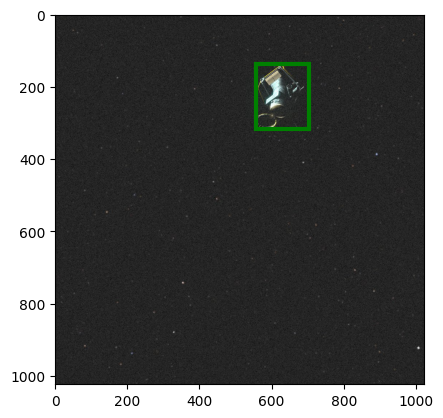

Displaying images for class: debris


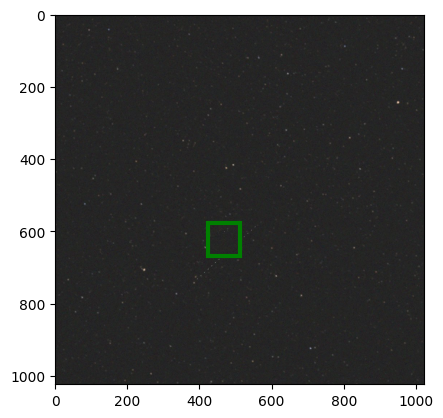

Displaying images for class: double_star


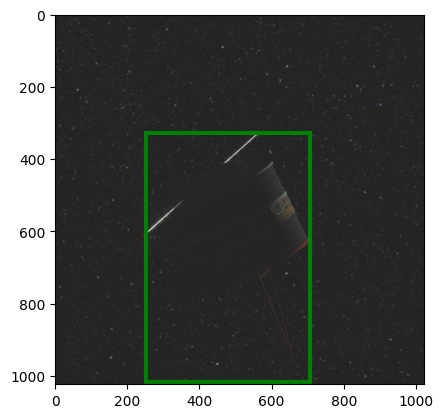

Displaying images for class: earth_observation_sat_1


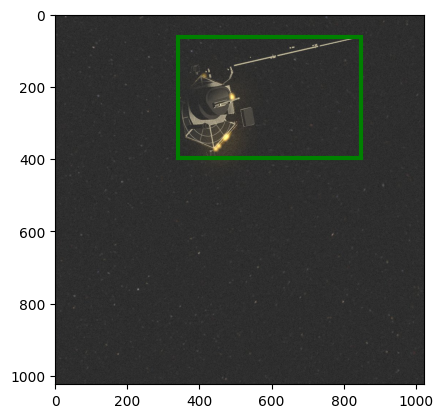

Displaying images for class: lisa_pathfinder


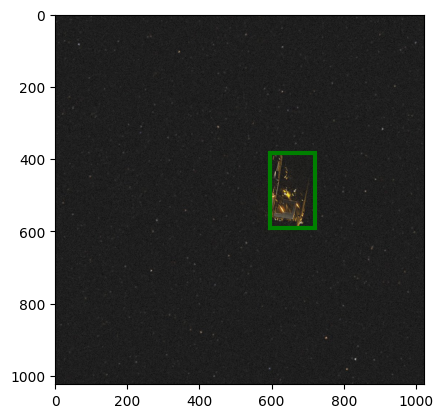

Displaying images for class: proba_2


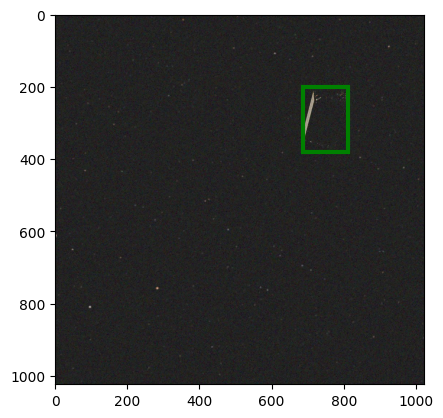

Displaying images for class: proba_3_csc


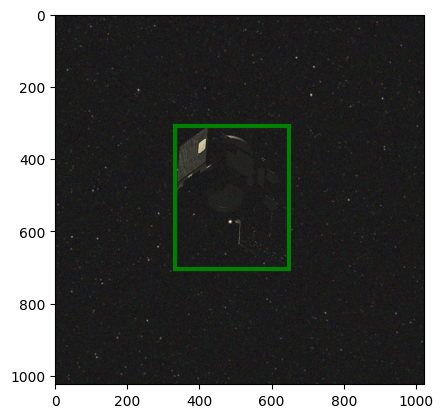

Displaying images for class: proba_3_ocs


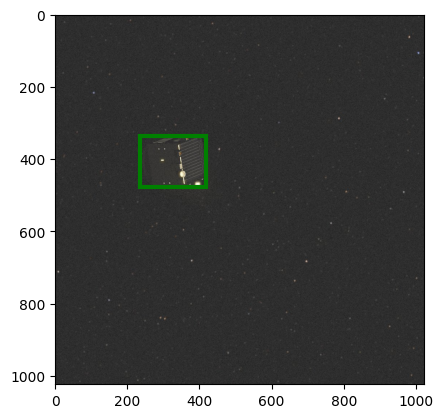

Displaying images for class: smart_1


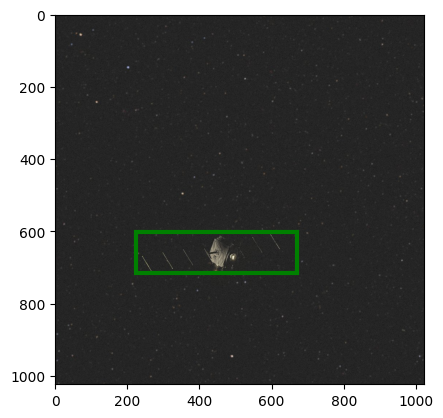

Displaying images for class: soho


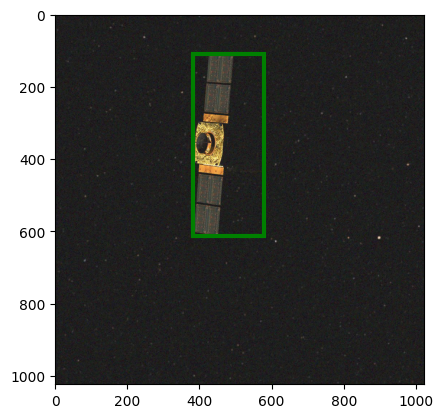

Displaying images for class: xmm_newton


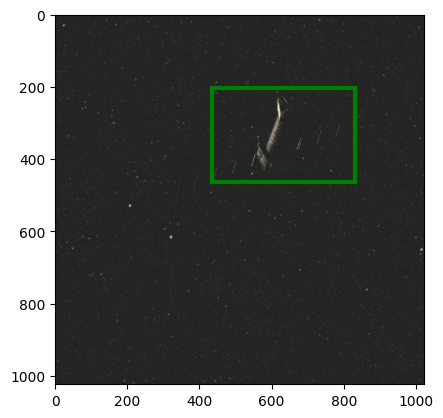

In [11]:
processor.show_image_per_class(predictions_df,test_images,sample=1)

## Validation 

In [6]:
model = YOLO(curr_dir+'/runs/detect/train2/weights/best.pt')  

# Validate the model
metrics = model.val(data = '/home/users/maali/Computer_vision_SOC/config.yaml')  
metrics.box.map50  # map50
metrics.box.maps 

Ultralytics YOLOv8.0.232 🚀 Python-3.8.6 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 268 layers, 68134161 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /mnt/irisgpfs/users/maali/Computer_vision_SOC/samples/val/labels... 2200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2200/2200 [00:03<00:00, 709.60it/s]


val: New cache created: /mnt/irisgpfs/users/maali/Computer_vision_SOC/samples/val/labels.cache


/mnt/irisgpfs/users/maali/ultra_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 7, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 138/138 [00:13<00:00,  9.91it/s]


                   all       2200       2200      0.951        0.9      0.942       0.79
               smart_1       2200        200       0.85      0.785      0.827      0.733
                cheops       2200        200      0.933      0.978      0.991       0.86
       lisa_pathfinder       2200        200      0.972       0.99      0.995      0.907
                debris       2200        200      0.985      0.972      0.992      0.783
                  soho       2200        200      0.905       0.85      0.905      0.724
           proba_3_ocs       2200        200      0.959       0.96      0.988      0.806
           proba_3_csc       2200        200      0.976       0.95      0.992      0.881
earth_observation_sat_1       2200        200      0.967      0.733      0.827      0.611
               proba_2       2200        200      0.975      0.955      0.974      0.846
            xmm_newton       2200        200      0.969      0.794      0.895      0.714
           double_st

array([    0.73341,     0.86031,     0.90712,     0.78348,     0.72359,      0.8057,     0.88116,     0.61117,     0.84646,     0.71373,      0.8264])

# Limitations Analysis


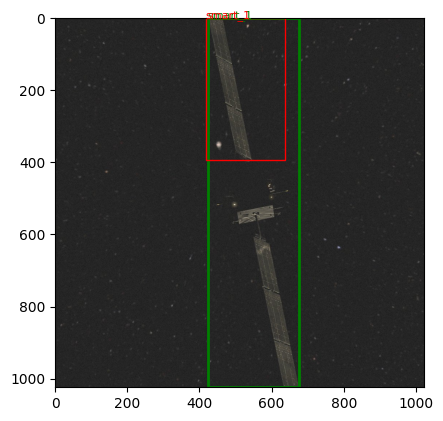

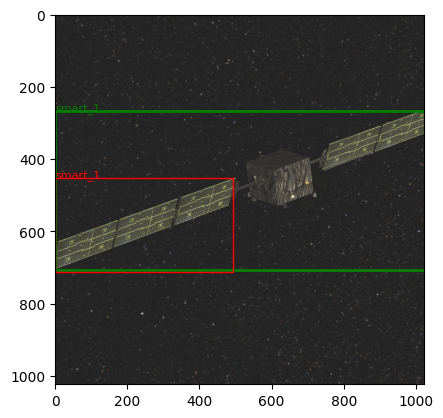

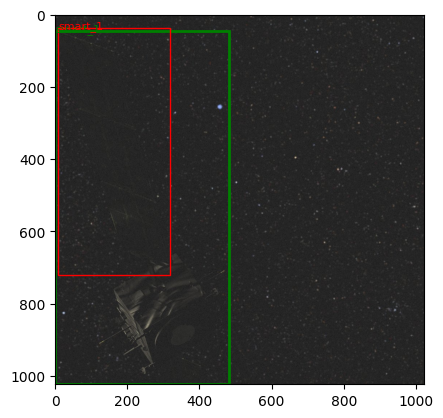

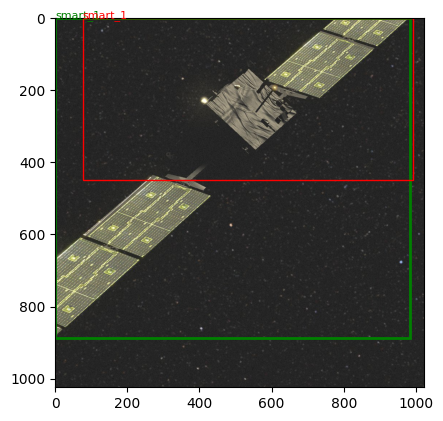

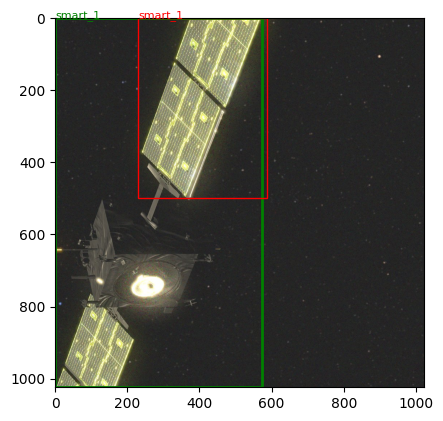

In [3]:
false_positives_df = detector.collect_false_positives(true_df, predictions_df,iou_scores)

detector.show_false_positives(false_positives_df,test_images,sample_size=5, classname='smart_1')

Statistics regarding the false positives, no detections and miss_classifications

In [4]:
all_classes_stats = detector.miss_stats(true_df, predictions_df,false_positives_df,all_labels)
all_classes_stats

,nbr_Images,False_positives,No_detections,Miss_classification
proba_3_ocs,200,24 (12.00%),22 (11.00%),19 (9.50%)
earth_observation_sat_1,200,28 (14.00%),36 (18.00%),14 (7.00%)
smart_1,200,29 (14.50%),22 (11.00%),5 (2.50%)
soho,200,4 (2.00%),6 (3.00%),4 (2.00%)
double_star,200,11 (5.50%),12 (6.00%),4 (2.00%)
cheops,200,9 (4.50%),1 (0.50%),3 (1.50%)
proba_2,200,6 (3.00%),6 (3.00%),3 (1.50%)
lisa_pathfinder,200,2 (1.00%),0 (0.00%),2 (1.00%)
xmm_newton,200,18 (9.00%),32 (16.00%),2 (1.00%)
debris,200,0 (0.00%),5 (2.50%),0 (0.00%)
